In [11]:
from tensorflow_probability import edward2 as ed
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import inferpy as inf 

In [12]:
D = 2
K = 2
N = 1000

In [13]:
###### DATA SAMPLES ######
# Define two normal distribution
aux1 = inf.models.Normal(loc=tf.ones([D])*1, scale = 1)
aux2 = inf.models.Normal(loc=tf.ones([D])*10, scale = 1)
# Stack 300 samples from the first and 700 from the second
x = np.vstack([aux1.sample(300), aux2.sample(700)])
np.random.shuffle(x)

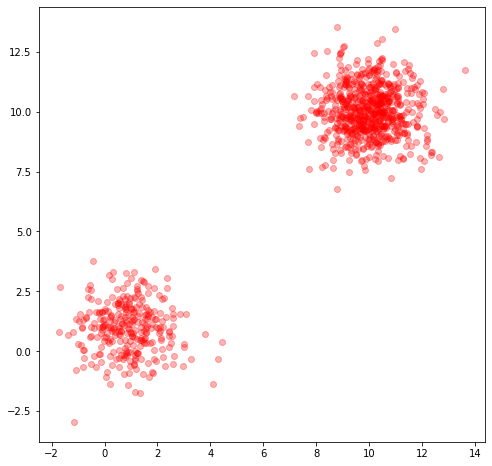

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(x[:,0],x[:,1],'ro',alpha=0.3)
plt.show()

In [15]:
# Gaussiam Mixture Model
@inf.probmodel
def gaussian_mixture(N, K, D, m0, b0, w0, v0, alpha0):
    pi = inf.Dirichlet(np.ones(K)*alpha0, name="pi")
    with inf.datamodel(K):
        sigma = inf.InverseGamma(concentration = tf.ones(D)*w0, scale = v0, name="lambda")
        mu = inf.Normal(tf.ones(D)*m0, b0*sigma, name="mu")
    with inf.datamodel(N):
        z = inf.Categorical(probs = pi, name="z")
        x = inf.Normal(tf.gather(mu,z), tf.gather(sigma,z), name="x")

m = gaussian_mixture(N = N, K = K, D = D, m0 = 1, b0 = 1, w0 = 1, v0 = 1, alpha0 = 1)

In [16]:
m.prior().parameters()

{'pi': {'name': 'pi',
  'allow_nan_stats': True,
  'validate_args': False,
  'concentration': array([1., 1.], dtype=float32)},
 'lambda': {'name': 'lambda',
  'rate': None,
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': 1,
  'concentration': array([1., 1.], dtype=float32)},
 'mu': {'name': 'mu',
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': array([[ 1.9147367, 12.128911 ],
         [ 5.5019355,  4.367568 ]], dtype=float32),
  'loc': array([1., 1.], dtype=float32)},
 'z': {'name': 'z',
  'allow_nan_stats': True,
  'validate_args': False,
  'dtype': tf.int32,
  'probs': array([0.43410587, 0.5658941 ], dtype=float32),
  'logits': None},
 'x': {'name': 'x',
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': array([[0.48285577, 3.5705276 ],
         [0.5484303 , 3.8981812 ],
         [0.48285577, 3.5705276 ],
         ...,
         [0.48285577, 3.5705276 ],
         [0.48285577, 3.5705276 ],
         [0.48285577, 3.5705276 ]], dtype=float32),


(1000, 2)


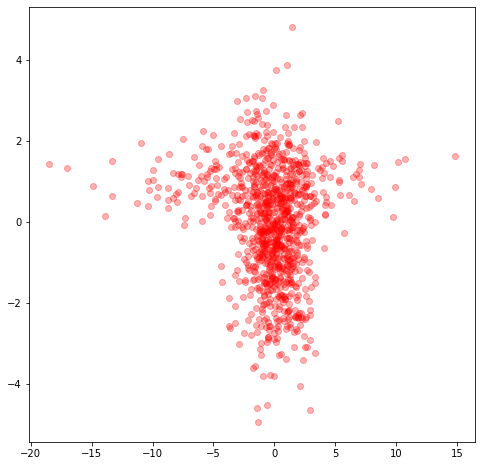

In [17]:
# Show a sample from the model
aux_sample = m.prior("x").sample(1)
print(aux_sample.shape)
plt.figure(figsize=(8, 8))
plt.plot(aux_sample[:,0], aux_sample[:,1],'ro',alpha=0.3)
plt.show()

In [21]:
@inf.probmodel
def qmodel(K,D):
    qpi_param = inf.Parameter(tf.ones([K]), name="qpi_param")
    qpi = inf.Dirichlet(qpi_param, name="pi")
    with inf.datamodel(K):
        qsigma_w = inf.Parameter(tf.ones([D]), name="qlambda_w")
        qsigma_v = inf.Parameter(tf.ones([D]), name="qlambda_v")
        sigma = inf.InverseGamma(concentration = qsigma_w, scale = qsigma_v, name="lambda")
        
        qmu_m = inf.Parameter(tf.ones([D]), name="qmu_m")
        qmu_b = inf.Parameter(tf.ones([D]), name="qmu_b")
        qmu = inf.Normal(qmu_m, qmu_b, name="mu")
        
    with inf.datamodel():
        qz_param = inf.Parameter(tf.ones([K]), name="qz_param")
        qz = inf.Categorical(probs = qz_param, name="z")
        
qmodel(K,D).prior().sample()

OrderedDict([('pi', array([0.89369625, 0.10630371], dtype=float32)),
             ('lambda',
              array([[0.5811782 , 1.1892956 ],
                     [1.2248513 , 0.87654954]], dtype=float32)),
             ('mu',
              array([[1.6121236, 1.7096418],
                     [1.6269479, 1.9201605]], dtype=float32)),
             ('z', array([0], dtype=int32))])

In [22]:
q = qmodel(K,D)
VI = inf.inference.VI(q, epochs=2000)
m.fit({"x": x}, VI)

/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/inferpy/models/prob_model.py:187: UserWarning: Fit was called before. This will restart the inference method and                 re-build the expanded model.
  re-build the expanded model.")



 0 epochs	 43453.84765625....................
 200 epochs	 31808.865234375....................
 400 epochs	 8907.19921875....................
 600 epochs	 376987.84375....................
 800 epochs	 20876.224609375....................
 1000 epochs	 29190.037109375....................
 1200 epochs	 17882.177734375....................
 1400 epochs	 19379.73828125....................
 1600 epochs	 30116.896484375....................
 1800 epochs	 9188.3486328125....................

In [23]:
m.posterior().parameters()

{'pi': {'name': 'pi',
  'allow_nan_stats': True,
  'validate_args': False,
  'concentration': array([1.2948059, 1.2201655], dtype=float32)},
 'lambda': {'name': 'lambda',
  'rate': None,
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': array([[1.321679 , 1.3228077],
         [1.3557975, 1.3290241]], dtype=float32),
  'concentration': array([[0.46421131, 0.44217083],
         [0.4599245 , 0.47178817]], dtype=float32)},
 'mu': {'name': 'mu',
  'allow_nan_stats': True,
  'validate_args': False,
  'scale': array([[0.9792751 , 0.93649495],
         [0.9081111 , 0.9194289 ]], dtype=float32),
  'loc': array([[1.3646708, 1.3519207],
         [1.3909588, 1.3665104]], dtype=float32)},
 'z': {'name': 'z',
  'allow_nan_stats': True,
  'validate_args': False,
  'dtype': tf.int32,
  'probs': array([[1.0106853 , 0.99043065]], dtype=float32),
  'logits': None}}

In [26]:
# Show a sample from the model
aux_sample = m.posterior().sample(1)
print(aux_sample)
print(aux_sample.shape)
plt.figure(figsize=(8, 8))
plt.plot(aux_sample[:,0], aux_sample[:,1],'ro',alpha=0.3)
plt.show()

{'pi': array([0.8201624 , 0.17983754], dtype=float32), 'lambda': array([[ 8.380479 ,  4.737528 ],
       [47.762356 ,  3.5468786]], dtype=float32), 'mu': array([[ 1.5299584 ,  0.95567137],
       [-0.04597604,  0.9515819 ]], dtype=float32), 'z': array([1], dtype=int32)}


AttributeError: 'dict' object has no attribute 'shape'